# Logistic Regression, SVMs, and Gradient Optimization

*Please address questions to Professor Eric Larson, eclarson@smu.edu*

In this notebook we will explore methods of using logistic regression in `scikit-learn` and we will also investigate methods for gradient descent. Finally we will look at using support vector machines and investigate parameters of kernel functions. A basic understanding of `scikit-learn` is required to complete this notebook, but we start very basic. Note also that there are more efficient methods of separating testing and training data, but we will leave that for a later lecture. 

First let's load a dataset and prepare it for analysis. We will use pandas to load in data, and then prepare it for classification. We will be using the titanic dataset (a very modest sized data set of about 1000 instances) before loading a larger, more complicated dataset for gradient descent methods.

______
The imputation methods used here are discussed in a previous notebook. 

In [82]:
import pandas as pd
import numpy as np
from __future__ import print_function

df = pd.read_csv('data/titanic.csv') # read in the csv file

# 1. Remove attributes that just arent useful for us
del df['PassengerId']
del df['Name']
del df['Cabin']
del df['Ticket']

# 2. Impute some missing values, grouped by their Pclass and SibSp numbers
df_grouped = df.groupby(by=['Pclass','SibSp'])

# # now use this grouping to fill the data set in each group, then transform back
# fill in the numeric values
df_imputed = df_grouped.transform(lambda grp: grp.fillna(grp.median()))
# fill in the categorical values
df_imputed[['Sex','Embarked']] = df_grouped[['Sex','Embarked']].apply(lambda grp: grp.fillna(grp.mode()))
# fillin the grouped variables from original data frame
df_imputed[['Pclass','SibSp']] = df[['Pclass','SibSp']]

# 3. Computed discrete features agains now with the newest values
df_imputed['age_range'] = pd.cut(df_imputed.Age,[0,16,24,65,1e6],4,labels=[0,1,2,3]) # this creates a new variable
# 4. drop rows that still had missing values after grouped imputation
df_imputed.dropna(inplace=True)
df_imputed.age_range = df_imputed.age_range.astype(np.int)
# 5. Rearrange the columns
df_imputed = df_imputed[['Survived','Age','age_range','Sex','Parch','SibSp','Pclass','Fare','Embarked']]

df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 882 entries, 0 to 890
Data columns (total 9 columns):
Survived     882 non-null int64
Age          882 non-null float64
age_range    882 non-null int64
Sex          882 non-null object
Parch        882 non-null int64
SibSp        882 non-null int64
Pclass       882 non-null int64
Fare         882 non-null float64
Embarked     882 non-null object
dtypes: float64(2), int64(5), object(2)
memory usage: 68.9+ KB


________
Now let's look a little further at each of the categorical objects. Note that age range has already been saved as an ordinal. We need to look at `Sex` and `Embarked` objects. 

In [83]:
# NOTE: calling describe when not all the data is categorical will cause the 
# categorical variables to be removed
df_imputed[['Sex','Embarked']].describe().transpose()

,count,unique,top,freq
Sex,882,2,male,573
Embarked,882,3,S,637


Because the `Sex`  attribute binary, there is no need to encode it using OneHotEncoding. We can just convert it to an integer. However, we should transform the `Embarked` attribute to take on three different values--one for each possible variable outcome.

In [84]:
# perform one-hot encoding of the categorical data "embarked"
tmp_df = pd.get_dummies(df_imputed.Embarked,prefix='Embarked')
df_imputed = pd.concat((df_imputed,tmp_df),axis=1) # add back into the dataframe

# replace the current Sex atribute with something slightly more intuitive and readable
df_imputed['IsMale'] = df_imputed.Sex=='male' 
df_imputed.IsMale = df_imputed.IsMale.astype(np.int)

df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 882 entries, 0 to 890
Data columns (total 13 columns):
Survived      882 non-null int64
Age           882 non-null float64
age_range     882 non-null int64
Sex           882 non-null object
Parch         882 non-null int64
SibSp         882 non-null int64
Pclass        882 non-null int64
Fare          882 non-null float64
Embarked      882 non-null object
Embarked_C    882 non-null uint8
Embarked_Q    882 non-null uint8
Embarked_S    882 non-null uint8
IsMale        882 non-null int64
dtypes: float64(2), int64(6), object(2), uint8(3)
memory usage: 78.4+ KB


In [85]:
# Now let's clean up the dataset
if 'Sex' in df_imputed:
    del df_imputed['Sex'] # if 'Sex' column still exists, delete it (as we created an ismale column)
    
if 'Embarked' in df_imputed:    
    del df_imputed['Embarked'] # get reid of the original category as it is now one-hot encoded
    
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 882 entries, 0 to 890
Data columns (total 11 columns):
Survived      882 non-null int64
Age           882 non-null float64
age_range     882 non-null int64
Parch         882 non-null int64
SibSp         882 non-null int64
Pclass        882 non-null int64
Fare          882 non-null float64
Embarked_C    882 non-null uint8
Embarked_Q    882 non-null uint8
Embarked_S    882 non-null uint8
IsMale        882 non-null int64
dtypes: float64(2), int64(6), uint8(3)
memory usage: 64.6 KB


In [86]:
# Finally, let's create a new variable based on the number of family members
# traveling with the passenger

# notice that this new column did not exist before this line of code--we use the pandas 
#    syntax to add it in 
df_imputed['FamilySize'] = df_imputed.Parch + df_imputed.SibSp
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 882 entries, 0 to 890
Data columns (total 12 columns):
Survived      882 non-null int64
Age           882 non-null float64
age_range     882 non-null int64
Parch         882 non-null int64
SibSp         882 non-null int64
Pclass        882 non-null int64
Fare          882 non-null float64
Embarked_C    882 non-null uint8
Embarked_Q    882 non-null uint8
Embarked_S    882 non-null uint8
IsMale        882 non-null int64
FamilySize    882 non-null int64
dtypes: float64(2), int64(7), uint8(3)
memory usage: 71.5 KB


___
# Training and Testing Split
For training and testing purposes, let's gather the data we have and grab 80% of the instances for training and the remaining 20% for testing. Moreover, let's repeat this process of separating the testing and training data three times. We will use the hold out cross validation method built into `scikit-learn`.

In [87]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'Survived' in df_imputed:
    y = df_imputed['Survived'].values # get the labels we want
    del df_imputed['Survived'] # get rid of the class label
    X = df_imputed.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


___
# Logistic Regression
Now let's use Logistic Regression from `scikit-learn`. The documentation can be found here:

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [90]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1
    
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

====Iteration 0  ====
accuracy 0.824858757062
confusion matrix
 [[95 12]
 [19 51]]
====Iteration 1  ====
accuracy 0.870056497175
confusion matrix
 [[105   6]
 [ 17  49]]
====Iteration 2  ====
accuracy 0.757062146893
confusion matrix
 [[92 23]
 [20 42]]


In [93]:
# this does the exact same thing as the above block of code, but with shorter syntax

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    lr_clf.fit(X[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))

====Iteration 0  ====
accuracy 0.751412429379
confusion matrix
 [[89 19]
 [25 44]]
====Iteration 1  ====
accuracy 0.802259887006
confusion matrix
 [[81 16]
 [19 61]]
====Iteration 2  ====
accuracy 0.80790960452
confusion matrix
 [[104  16]
 [ 18  39]]


In [97]:
# and here is an even shorter way of getting the accuracies for each training and test set
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object) # this also can help with parallelism
print(accuracies)

[ 0.79661017  0.81920904  0.76836158]


In [98]:
# here we can change some of the parameters interactively
from ipywidgets import widgets as wd

def lr_explor(cost):
    lr_clf = LogisticRegression(penalty='l2', C=cost, class_weight=None) # get object
    accuracies = cross_val_score(lr_clf,X,y=y,cv=cv_object) # this also can help with parallelism
    print(accuracies)

wd.interact(lr_explor,cost=(0.001,5.0,0.05),__manual=True)

[ 0.81355932  0.78531073  0.83050847]


## Interpretting weights
Okay, so now lets take the last trained model for logistic regression and try to interpret the weights for the model. Is there something about the weights that makes this model more interpretable?

In [99]:
# interpret the weights

# iterate over the coefficients
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = df_imputed.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])
    
# does this look correct? 

Age has weight of -0.0265630403308
age_range has weight of -0.0555900718049
Parch has weight of 0.0935073941523
SibSp has weight of -0.207763994097
Pclass has weight of -0.836681151402
Fare has weight of 0.00355375375476
Embarked_C has weight of 1.39178703441
Embarked_Q has weight of 0.812272647194
Embarked_S has weight of 0.780796854562
IsMale has weight of -2.4931910785
FamilySize has weight of -0.114256599945


These weight interpretations **are not neccessarily interpretable** because of the values we had. Very large attribute values could just as easily be assigned a higher weight. Instead, let's normalize the feature values so that all the attributes are on the same dynamic range. Once we normalize the attributes, the weights should have magnitudes that reflect their poredictive power in the logistic regression model.
___

In [100]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05) # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df_imputed.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

accuracy: 0.751412429379
[[90 25]
 [19 43]]
IsMale has weight of -1.07335140169
Pclass has weight of -0.628626575831
Age has weight of -0.247560073014
Embarked_S has weight of -0.124745984722
FamilySize has weight of -0.0817267917372
SibSp has weight of -0.0698547568384
Parch has weight of -0.0661937879072
age_range has weight of -0.0418078146623
Embarked_Q has weight of 0.0501779960716
Embarked_C has weight of 0.106674354518
Fare has weight of 0.189791285482


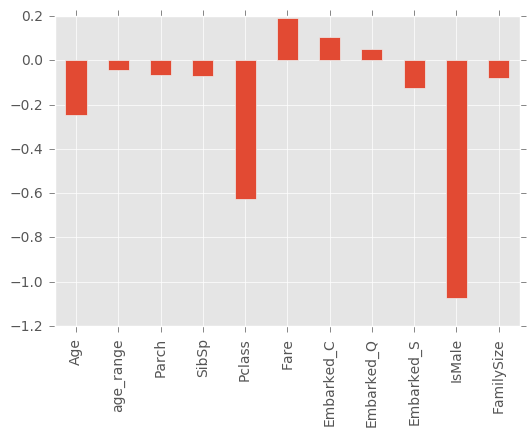

In [101]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(lr_clf.coef_[0],index=df_imputed.columns)
weights.plot(kind='bar')
plt.show()

**For more improvement and guarding against overfitting:** At this point it would make sense to remove variables that are highly related to one another or ones that are irrelevant and keep going with the weights analysis. What variables would you remove?
___

In [102]:
from sklearn.preprocessing import StandardScaler
# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)

from sklearn.pipeline import Pipeline
# you can apply the StandardScaler function inside of the cross-validation loop 
#  but this requires the use of PipeLines in scikit. 
#  A pipeline can apply feature pre-processing and data fitting in one compact notation
#  Here is an example!

std_scl = StandardScaler()
lr_clf = LogisticRegression(penalty='l2', C=0.05) 

# create the pipline
piped_object = Pipeline([('scale', std_scl),  # do this
                         ('logit_model', lr_clf)]) # and then do this

weights = []
# run the pipline cross validated
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    piped_object.fit(X[train_indices],y[train_indices])  # train object
    # it is a little odd getting trained objects from a  pipeline:
    weights.append(piped_object.named_steps['logit_model'].coef_[0])
    

weights = np.array(weights)

In [25]:
import plotly
plotly.offline.init_notebook_mode() # run at the start of every notebook

error_y=dict(
            type='data',
            array=np.std(weights,axis=0),
            visible=True
        )

graph1 = {'x': df_imputed.columns,
          'y': np.mean(weights,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars'}

plotly.offline.iplot(fig)

**For more improvement and guarding against overfitting:** At this point it would make sense to remove variables that are highly related to one another or ones that are irrelevant and keep going with the weights analysis. What variables would you remove?

In [103]:
Xnew = df_imputed[['Age','Pclass','IsMale']].values

weights = []
# run the pipline corssvalidated
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(Xnew,y)):
    piped_object.fit(Xnew[train_indices],y[train_indices])  # train object
    weights.append(piped_object.named_steps['logit_model'].coef_[0])
    
weights = np.array(weights)

error_y=dict(
            type='data',
            array=np.std(weights,axis=0),
            visible=True
        )

graph1 = {'x': ['Age','Pclass','IsMale'],
          'y': np.mean(weights,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars'}

plotly.offline.iplot(fig)

# Support Vector Machines
We can use the previous training and testing attributes (scaled) to investigate the weights and support vectors in the attributes. SVMs were first hypothesized by Vladmir Vapnik ~50 years ago, but did not gain popularity until the turn of the millenium. 

In [27]:
from IPython.display import Image
# Here he is, in all his glory:
Image(url='http://engineering.columbia.edu/files/engineering/vapnik.jpg')
# Image(url='http://yann.lecun.com/ex/images/allyourbayes.jpg')

In [104]:
# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) 

In [112]:
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.858757062147
[[107   9]
 [ 16  45]]


In [110]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(356, 11)
(356,)
[182 174]


In [113]:
# if using linear kernel, these make sense to look at (not otherwise, why?)
print(svm_clf.coef_)
weights = pd.Series(svm_clf.coef_[0],index=df_imputed.columns)
weights.plot(kind='bar')

ValueError: coef_ is only available when using a linear kernel

In [32]:
# Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors

# now lets look at the support for the vectors and see if we they are indicative of anything
# grabe the rows that were selected as support vectors (these are usually instances that are hard to classify)

# make a dataframe of the training data
df_tested_on = df_imputed.iloc[train_indices] # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:]

df_support['Survived'] = y[svm_clf.support_] # add back in the 'Survived' Column to the pandas dataframe
df_imputed['Survived'] = y # also add it back in for the original data
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335 entries, 757 to 507
Data columns (total 12 columns):
Age           335 non-null float64
age_range     335 non-null int64
Parch         335 non-null int64
SibSp         335 non-null int64
Pclass        335 non-null int64
Fare          335 non-null float64
Embarked_C    335 non-null uint8
Embarked_Q    335 non-null uint8
Embarked_S    335 non-null uint8
IsMale        335 non-null int64
FamilySize    335 non-null int64
Survived      335 non-null int64
dtypes: float64(2), int64(7), uint8(3)
memory usage: 27.2 KB


/Users/eclarson/anaconda/envs/MLEnv/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



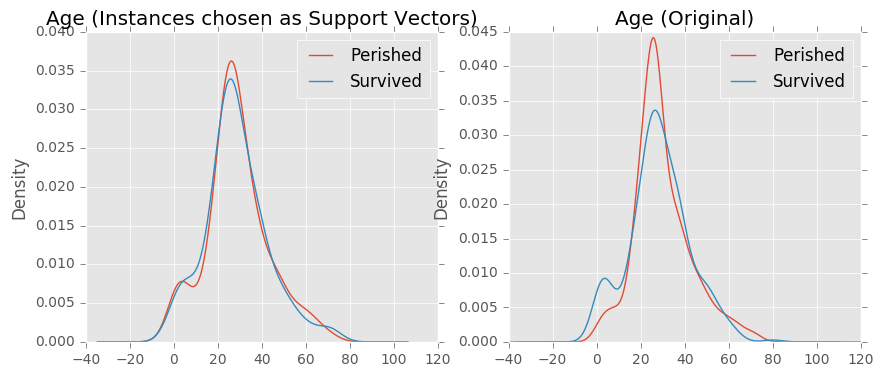

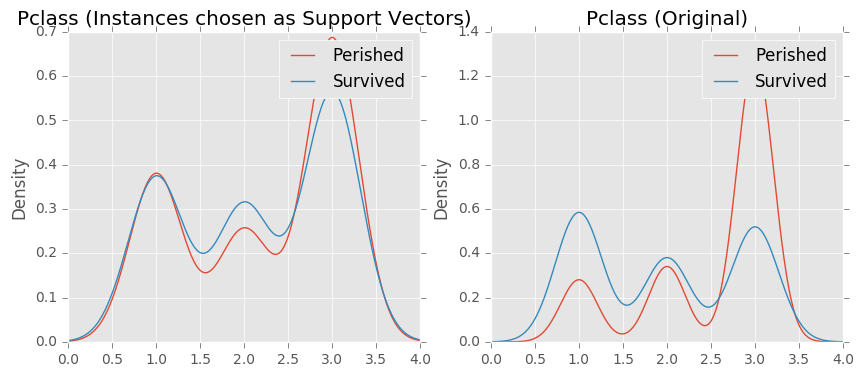

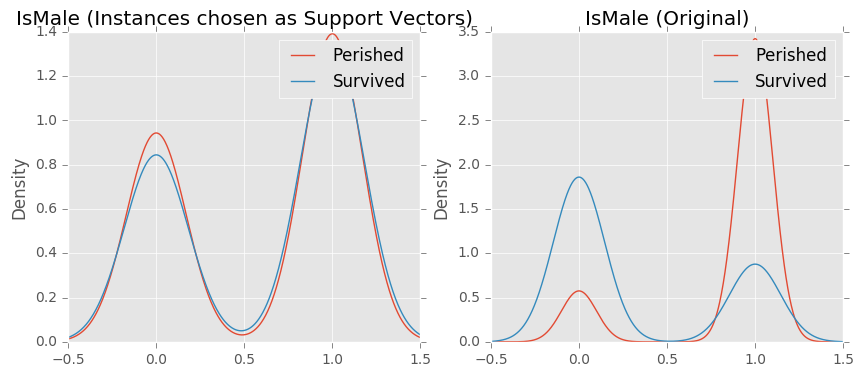

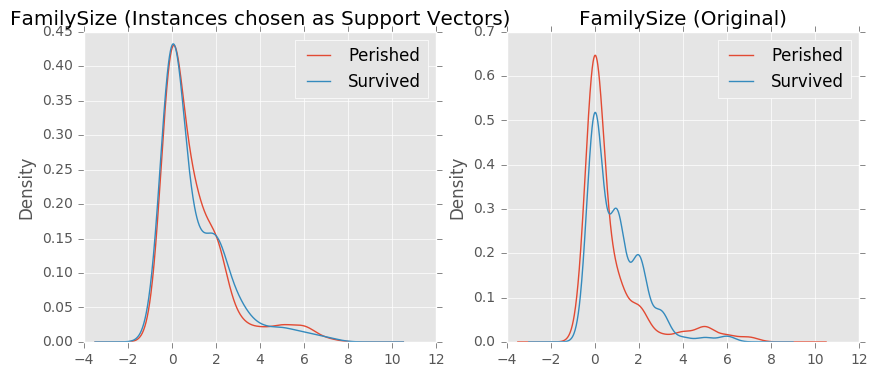

In [33]:
# now lets see the statistics of these attributes
from pandas.tools.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['Survived'])
df_grouped = df_imputed.groupby(['Survived'])

# plot KDE of Different variables
vars_to_plot = ['Age','Pclass','IsMale','FamilySize']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Perished','Survived'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Perished','Survived'])
    plt.title(v+' (Original)')



So the analysis here is basically telling us what the original statistics of the data looked like, and also what the statistics of the support vectors looked like. We can see that the separation in distributions is not as great as the separation for the original data. This is because the support vectors tend to be instances on the edge of the class boundaries and also instances that are classified incorrectly in the training data. 

You can also look at joint plots of the data and see how relationships have changed. (**Hint hint for the min-lab assignment**--this would be a nice analysis of the support vectors.)

That's mostly it for using these things! They are really nice analysis tools and provide human interpretable summaries of the data. 
___

# Gradient Based Alternatives
So now let's go and find out how we can use these when our data size gets bigger. Like a lot bigger. We will use a kaggle dataset that attempts to classify plankton. We will use some example code to get us started from the tutorial here:
http://www.kaggle.com/c/datasciencebowl/details/tutorial 

You can download from Kaggle (login required): https://www.kaggle.com/c/datasciencebowl/data

UPDATE: This problem was also solved using deep learning! Check out the blog here:
http://benanne.github.io/2015/03/17/plankton.html 

In [34]:
Image(url='https://kaggle2.blob.core.windows.net/competitions/kaggle/3978/media/plankton%20schmorgasborg.jpg')

In [80]:
# load another dataset (large) and train using various methods of gradient (and mini-batch)
import glob
import os
from __future__ import print_function

# change this to point to the dataset on your machine/cluster!!
# For my students: please email me for a link to the data if you cannot get it from Kaggle
directory_of_dataset = "/Users/eclarson/Desktop/"

# get the classnames from the directory structure
directory_names = list(set(glob.glob(os.path.join(directory_of_dataset,"kaggle_plank", "*"))
 ).difference(set(glob.glob(os.path.join(directory_of_dataset,"kaggle_plank","*.*")))))

print('number of classes:', len(directory_names))

number of classes: 121


In [81]:
# using this code requires the use of skimage to process the images (you will need to install via pip)
import pandas as pd
import numpy as np

# Rescale the images and create the combined metrics and training labels
from skimage.transform import resize
from skimage.io import imread

#get the total training images
numberofImages = 0
for folder in directory_names:
    for fileNameDir in os.walk(folder):   
        for fileName in fileNameDir[2]:
             # Only read in the images
            if fileName[-4:] != ".jpg":
              continue
            numberofImages += 1

# We'll rescale the images to be 40x40
maxPixel = 25
imageSize = maxPixel * maxPixel
num_rows = numberofImages # one row for each image in the training dataset
num_features = imageSize # for our ratio

# X is the feature vector with one row of features per image
# consisting of the pixel values and our metric
X = np.zeros((num_rows, num_features), dtype=float)
# y is the numeric class label 
y = np.zeros((num_rows))

files = []
# Generate training data
i = 0    
label = 0
# List of string of class names
namesClasses = list()

print("Reading images")
# Navigate through the list of directories
for folder in directory_names:
    # Append the string class name for each class
    currentClass = folder.split(os.pathsep)[-1]
    namesClasses.append(currentClass)
    for fileNameDir in os.walk(folder):   
        for fileName in fileNameDir[2]:
            # Only read in the images
            if fileName[-4:] != ".jpg":
              continue
            
            # Read in the images and create the features
            nameFileImage = "{0}{1}{2}".format(fileNameDir[0], os.sep, fileName)            
            image = imread(nameFileImage, as_grey=True)
            files.append(nameFileImage)
            #axisratio = getMinorMajorRatio(image)
            image = resize(image, (maxPixel, maxPixel))
            
            # Store the rescaled image pixels and the axis ratio
            X[i, 0:imageSize] = np.reshape(image, (1, imageSize))
            #X[i, imageSize] = axisratio
            
            # Store the classlabel
            y[i] = label
            i += 1
            # report progress for each 5% done  
            report = [int((j+1)*num_rows/20.) for j in range(20)]
            if i in report: print(np.ceil(i *100.0 / num_rows), "% done")
    label += 1

Reading images
5.0 % done
10.0 % done
15.0 % done
20.0 % done
25.0 % done
30.0 % done
35.0 % done
40.0 % done
45.0 % done
50.0 % done
55.0 % done
60.0 % done
65.0 % done
70.0 % done
75.0 % done
80.0 % done
85.0 % done
90.0 % done
95.0 % done
100.0 % done


In [37]:
# here is where the online tutorial code stops and my code starts
print(X.shape)
print(y.shape)

(30336, 625)
(30336,)


In [44]:
# now divide the data into test and train using scikit learn built-ins
from sklearn.model_selection import StratifiedShuffleSplit 

cv = StratifiedShuffleSplit( n_splits=1,test_size=0.5)

In [45]:
%%time
# use some compact notation for creating a linear SVM classifier with stichastic descent
from sklearn.linear_model import SGDClassifier

regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,y):
    svm_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = svm_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('SVM:', acc)

SVM: 0.275909810127
CPU times: user 13.2 s, sys: 147 ms, total: 13.4 s
Wall time: 4.04 s


In [46]:
%%time
# use some compact notation for creating a logistic regression classifier with stochastic descent
log_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,y):
    log_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = log_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('Logistic Regression:', acc)

Logistic Regression: 0.283227848101
CPU times: user 26.5 s, sys: 145 ms, total: 26.6 s
Wall time: 7.31 s


In [47]:
%%time
# now lets use some of what we know from this class to reduce the dimensionality of the set
from sklearn.decomposition import PCA
n_components = 50

pca = PCA(n_components=n_components, svd_solver='randomized')

iterations = 150
log_sgd = SGDClassifier(
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter=iterations, n_jobs=-1, penalty='l2')

# you could also set this up in a pipeline
for train_idx, test_idx in cv.split(X,y):
    log_sgd.fit(pca.fit_transform(X[train_idx]),y[train_idx])
    yhat = log_sgd.predict(pca.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('Logistic Regression:', acc)

Logistic Regression: 0.34368407173
CPU times: user 2min 6s, sys: 413 ms, total: 2min 6s
Wall time: 33.6 s


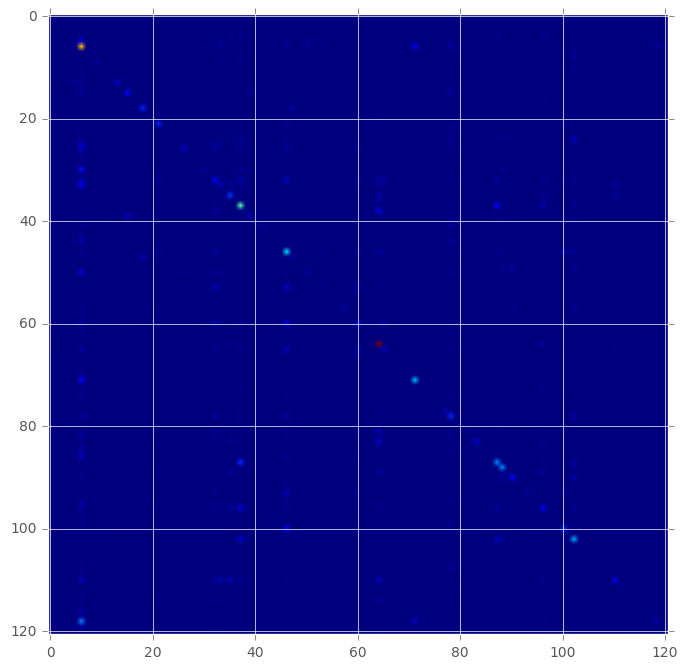

In [48]:
f = plt.figure(figsize=(8,8))
plt.imshow(conf)

The competition does not use "accuracy" as the evaluation of the best model; they use the log loss:
$$logloss=-\frac{1}{N}\sum_{i=1}^m\sum_{j=1}^C {\bf 1}_{ij}\ln(p_{ij})$$

Where there are $m$ instances (images) in the dataset, and $C$ is the number of classes. The equation ${\bf 1}_{ij}$ is an indicator function that ensures we only add log probabilities when the class is correct. That is, it is zero if the predicted class for the $i^{th}$ instance is not equal to $j$ and it is one when the class of the $i^{th}$ instance == $j$. To prevent extremities in the log function they also replace probabilities, $p$, with $p=\max(\min(p,1-10^{-15}),10^{-15})$

Would this be easy to code in python? `scikit-learn` has an implementation for log loss, but it is not exactly what the competition uses and is only defined for binary classes.

In [43]:
# from the tutorial: http://www.kaggle.com/c/datasciencebowl/details/tutorial 
def multiclass_log_loss(y_true, y_pred, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    https://www.kaggle.com/wiki/MultiClassLogLoss

    Parameters
    ----------
    y_true : array, shape = [n_samples]
            true class, integers in [0, n_classes - 1)
    y_pred : array, shape = [n_samples, n_classes]

    Returns
    -------
    loss : float
    """
    predictions = np.clip(y_pred, eps, 1 - eps)

    # normalize row sums to 1
    predictions /= predictions.sum(axis=1)[:, np.newaxis]

    actual = np.zeros(y_pred.shape)
    n_samples = actual.shape[0]
    actual[np.arange(n_samples), y_true.astype(int)] = 1
    vectsum = np.sum(actual * np.log(predictions))
    loss = -1.0 / n_samples * vectsum
    return loss

___
## How do you think you might increase the accuracy of the classifier(s)?
- Search through parameters for models?
- Try different classifiers?
- Add more features (through better image processing)?

___
## How do you think we can make the algorithms more efficient for training/testing?
- What about mini-batch training? 
- Sampling?
- Map/Reduce (what are advantages/disadvantages)?
- Buy a ton of memory on AWS virtual machines?

**Note:** For mini-batch calculations (they are not really needed here because the dataset fits in memory) they can be accessed for a number of different classifiers (including SGDClassifier) by managing the sub-samples we send it, $X_{sub}$, and calling the function `partial_fit`.